# Multi-Class Prediction

## Import the Libraries

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import  os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Gathering Data

*Combine and Load the train data table*

In [3]:
TRAIN_DT = pd.concat( 
    map(pd.read_csv, ['csv/bmi_train.csv', 'csv/bmi.csv']), ignore_index=True) 
TRAIN_DT.head()

,Gender,Height,Weight,Index
0,Male,161,89,4
1,Male,179,127,4
2,Male,172,139,5
3,Male,153,104,5
4,Male,165,68,2


*Load the validation data table*

In [4]:
VALIDATION_DT = pd.read_csv('csv/bmi_validation.csv')
VALIDATION_DT.head()

,Gender,Height,Weight
0,Male,161,103
1,Male,180,75
2,Male,174,95
3,Female,179,103
4,Female,192,140


## Assessing Data

In [5]:
TRAIN_DT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  900 non-null    object
 1   Height  900 non-null    int64 
 2   Weight  900 non-null    int64 
 3   Index   900 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 28.3+ KB


In [6]:
VALIDATION_DT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  100 non-null    object
 1   Height  100 non-null    int64 
 2   Weight  100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


*Looking for empty or null data/cell in dataset*

In [7]:
TRAIN_DT.isna().sum()

Gender    0
Height    0
Weight    0
Index     0
dtype: int64

In [8]:
VALIDATION_DT.isna().sum()

Gender    0
Height    0
Weight    0
dtype: int64

*Looking for duplicated data in dataset*

In [9]:
TRAIN_DT.duplicated().sum()

411

In [10]:
VALIDATION_DT.duplicated().sum()

0

## Preprocessing and Cleaning the Data

*Making copy of datasets and drop all the duplicates data in train dataset*

In [11]:
train_dt_c = TRAIN_DT.copy()
train_dt_c.drop_duplicates(inplace=True)

valid_dt_c = VALIDATION_DT.copy()

In [12]:
train_dt_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 489 entries, 0 to 897
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  489 non-null    object
 1   Height  489 non-null    int64 
 2   Weight  489 non-null    int64 
 3   Index   489 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.1+ KB


*Using map function to encoding the gender feature with numerical type, 0 for male and 1 for female*

In [13]:
train_dt_c['Gender'] = train_dt_c['Gender'].map({'Male': 0, 'Female': 1})
valid_dt_c['Gender'] = valid_dt_c['Gender'].map({'Male': 0, 'Female': 1})

*Separate the features and label for train dataset*

In [14]:
X = train_dt_c.drop('Index', axis=1)
Y = train_dt_c['Index']

In [15]:
X['BMI'] = X['Weight'] / ( (X['Height'] ** 2)/10000 )
X['BMI'] = X['BMI'].round(2)

In [16]:
X.head()

,Gender,Height,Weight,BMI
0,0,161,89,34.34
1,0,179,127,39.64
2,0,172,139,46.98
3,0,153,104,44.43
4,0,165,68,24.98


*Split the data into 70% Train, 15% Valid and 15% Test*

In [17]:
# Split the dataset into training and temp (validation + test)
x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)

# Split the temp dataset into validation and test sets
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

*Augmented the data*

In [18]:
x_train_augmented, y_train_augmented = resample(
    x_train, y_train, 
    n_samples=len(x_train),
    replace=True
)

In [19]:
# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Store the results for each fold
fold_accuracies = []

for train_index, val_index in kf.split(x_train_augmented):
    # Split the data into training and validation sets for this fold using .iloc
    x_train_fold, x_val_fold = x_train_augmented.iloc[train_index], x_train_augmented.iloc[val_index]
    y_train_fold, y_val_fold = y_train_augmented.iloc[train_index], y_train_augmented.iloc[val_index]

In [20]:
x_train.head()

,Gender,Height,Weight,BMI
433,1,160,131,51.17
3,0,153,104,44.43
348,1,155,115,47.87
717,0,142,135,66.95
60,1,150,70,31.11


In [21]:
y_train.head()

433    5
3      5
348    5
717    5
60     4
Name: Index, dtype: int64

## Exploring the data

In [22]:
x_train.describe(include="all")

,Gender,Height,Weight,BMI
count,342.000000,342.000000,342.000000,342.000000
mean,0.523392,170.254386,106.652047,37.781257
std,0.500184,15.989996,31.676221,13.479006
min,0.000000,140.000000,50.000000,12.750000
25%,0.000000,157.000000,81.000000,27.412500
50%,1.000000,171.000000,107.000000,36.970000
75%,1.000000,184.000000,135.750000,45.725000
max,1.000000,199.000000,160.000000,74.490000


In [23]:
y_train.describe(include="all")

count    342.000000
mean       3.774854
std        1.317226
min        0.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: Index, dtype: float64

In [24]:
valid_dt_c.describe(include="all")

,Gender,Height,Weight
count,100.00,100.000000,100.000000
mean,0.55,168.270000,105.760000
std,0.50,15.521803,32.626172
min,0.00,141.000000,51.000000
25%,0.00,156.000000,76.500000
50%,1.00,168.000000,103.500000
75%,1.00,180.250000,135.250000
max,1.00,197.000000,160.000000


In [25]:
print ('The shape of X_train is: ' + str(x_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

print ('\nThe shape of validation dataset is: ' + str(valid_dt_c.shape))
print ('We have m = %d validation examples' % (len(valid_dt_c)))

The shape of X_train is: (342, 4)
The shape of y_train is: (342,)
We have m = 342 training examples

The shape of validation dataset is: (100, 3)
We have m = 100 validation examples


## Visualize the Data

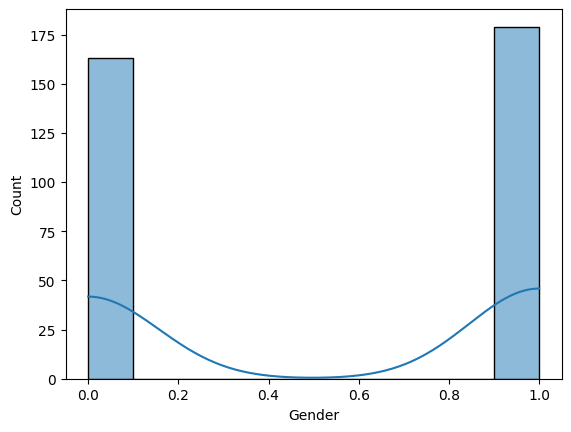

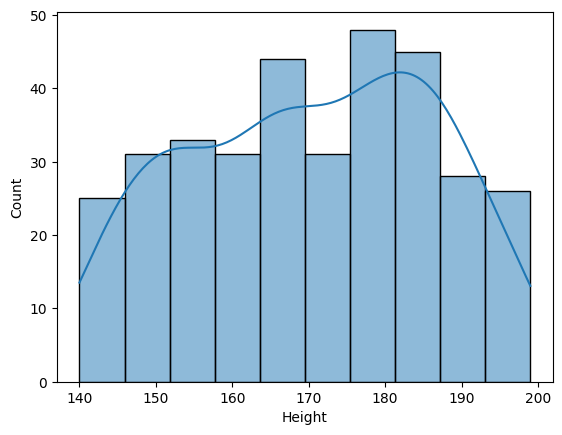

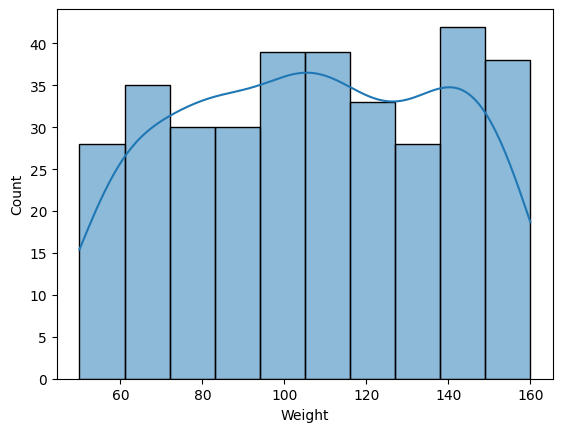

In [26]:
data = x_train['Gender']

# Histogram
sns.histplot(data, kde=True)
plt.show()

data = x_train['Height']

# Histogram
sns.histplot(data, kde=True)
plt.show()

data = x_train['Weight']

# Histogram
sns.histplot(data, kde=True)
plt.show()

## Training the Data

In [27]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(4,)),

    tf.keras.layers.Dense(90, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    
    tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    ]) 
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [28]:
print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 4)
Output shape: (None, 6)


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 90)                450       
                                                                 
 dense_1 (Dense)             (None, 64)                5824      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 6)                 198       
                                                                 
Total params: 8552 (33.41 KB)
Trainable params: 8552 (33.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
# ModelCheckpoint callback is used in conjunction with training using model.fit() 
# to save a model or weights (in a checkpoint file) at some interval, so the model 
# or weights can be loaded later to continue the training from the state saved.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore the best model weights
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)

history = model.fit(
    x_train_augmented, y_train_augmented,
    validation_data=(x_valid, y_valid),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=2
)

# model.save('bmi_augmented_model_2.keras')

Epoch 1/50


11/11 - 1s - loss: 8.9995 - accuracy: 0.2485 - val_loss: 5.5741 - val_accuracy: 0.3973 - lr: 5.0000e-04 - 1s/epoch - 117ms/step
Epoch 2/50
11/11 - 0s - loss: 3.6401 - accuracy: 0.4444 - val_loss: 1.6847 - val_accuracy: 0.5753 - lr: 5.0000e-04 - 42ms/epoch - 4ms/step
Epoch 3/50
11/11 - 0s - loss: 1.3913 - accuracy: 0.3567 - val_loss: 1.2496 - val_accuracy: 0.5068 - lr: 5.0000e-04 - 40ms/epoch - 4ms/step
Epoch 4/50
11/11 - 0s - loss: 1.0875 - accuracy: 0.5731 - val_loss: 0.8514 - val_accuracy: 0.6575 - lr: 5.0000e-04 - 40ms/epoch - 4ms/step
Epoch 5/50
11/11 - 0s - loss: 0.8511 - accuracy: 0.6579 - val_loss: 0.7614 - val_accuracy: 0.7534 - lr: 5.0000e-04 - 41ms/epoch - 4ms/step
Epoch 6/50
11/11 - 0s - loss: 0.7745 - accuracy: 0.6462 - val_loss: 0.7433 - val_accuracy: 0.6301 - lr: 5.0000e-04 - 42ms/epoch - 4ms/step
Epoch 7/50
11/11 - 0s - loss: 0.7091 - accuracy: 0.6901 - val_loss: 0.6424 - val_accuracy: 0.8082 - lr: 5.0000e-04 - 44ms/epoch - 4ms/step
Epoch 8/50
11/11 - 0s - l

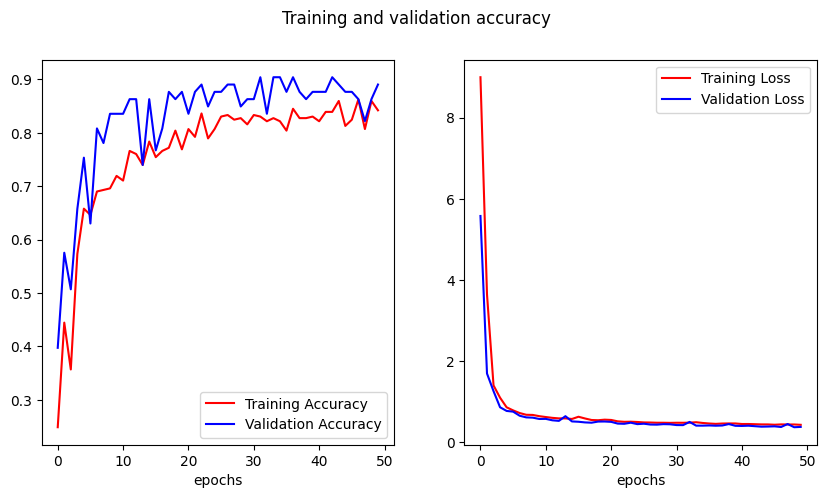

In [31]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

*Using the best model that have been saved using checkpoint callback*

In [32]:
# model = tf.keras.models.load_model("saved_modelsBMI/weights-improvment-35-0.44.keras")

In [33]:
# Predict the model
y_pred = model.predict(x_test)

y_pred_class = np.argmax(y_pred, axis=1)

accuracy = np.mean(y_test == y_pred_class)

# Print out the accuracy that based on comparing the y_test and the predicted labels
print(f'Accuracy: {accuracy*100:.2f}%')

3/3 [==============================] - 0s 2ms/step
Accuracy: 90.54%


In [34]:
# gender = int(input("Masukkan gender anda dalam 0 untuk pria / 1 untuk wanita: "))
# height = int(input("Masukkan tinggi badan anda: "))
# weight = int(input("Masukkan tinggi badan anda: "))

gender = 0
height = 175
weight = 65

bmi = np.round(weight/(height**2/10000), 2)

test_feature = np.array([
    [gender, height, weight, bmi]
])

In [35]:
# Predict the model
test_label_pred = model.predict(test_feature)
test_label_pred_class = np.argmax(test_label_pred)
print(f'Gender = {gender}\nHeight = {height}\nWeight = {weight}\nBMI = {bmi}\nPredict = {test_label_pred_class}')

1/1 [==============================] - 0s 51ms/step
Gender = 0
Height = 175
Weight = 65
BMI = 21.22
Predict = 2


In [36]:
# model.save('bmi_model-accuracy_0.90-loss_0.26-val_accuracy_0.91-val_loss_0.23.keras')

### Confusion Matrix

In [ ]:
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 342, number of used features: 4
[LightGBM] [Info] Start training from score -3.755369
[LightGBM] [Info] Start training from score -3.269861
[LightGBM] [Info] Start training from score -2.006169
[LightGBM] [Info] Start training from score -1.984663
[LightGBM] [Info] Start training from score -1.280934
[LightGBM] [Info] Start training from score -0.944462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

LGBMClassifier()

In [ ]:
y_pred=clf.predict(x_test)

accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9730


Compare train and test set accuracy

In [39]:
y_pred_train = clf.predict(x_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 1.0000


Check for overfitting

In [40]:
print('Training set score: {:.4f}'.format(clf.score(x_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(x_test, y_test)))

Training set score: 1.0000
Test set score: 0.9730


`The training and test set accuracy are quite comparable. So, we cannot say there is overfitting.`

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[ 3  0  0  0  0  0]
 [ 0  4  0  0  0  0]
 [ 0  0  9  0  1  0]
 [ 0  0  0 11  0  0]
 [ 0  0  0  0 13  0]
 [ 0  0  0  0  1 32]]


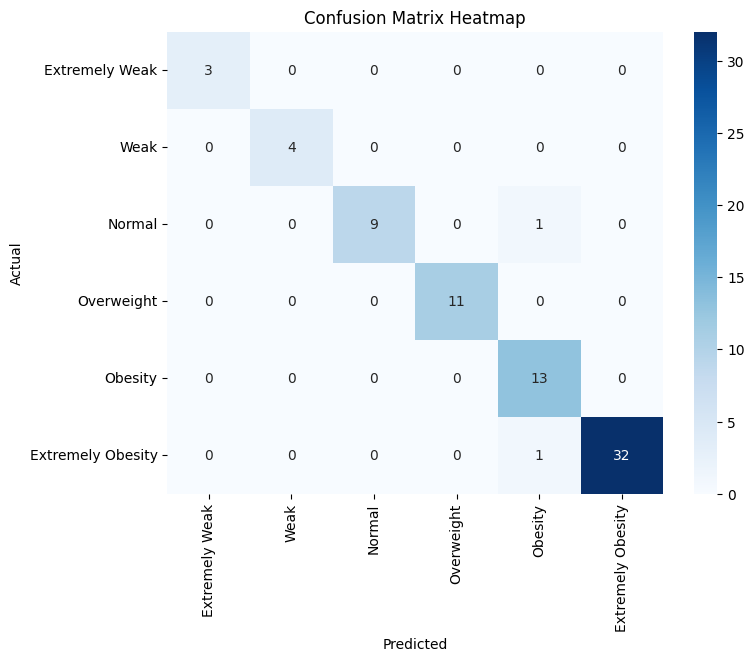

In [ ]:
# Define class labels
class_names = ['Extremely Weak', 'Weak', 'Normal', 'Overweight', 'Obesity', 'Extremely Obesity']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      0.90      0.95        10
           3       1.00      1.00      1.00        11
           4       0.87      1.00      0.93        13
           5       1.00      0.97      0.98        33

    accuracy                           0.97        74
   macro avg       0.98      0.98      0.98        74
weighted avg       0.98      0.97      0.97        74



- Hampir semua kelas memiliki precision, recall, dan F1-score mendekati 1.00, menunjukkan kinerja yang konsisten.
- Class 4 dan class 2 memiliki metrik yang sedikit lebih rendah, tetapi tetap berada pada tingkat performa yang baik.